# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Setup" data-toc-modified-id="Setup-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Setup</a></div><div class="lev3 toc-item"><a href="#Python-libraries" data-toc-modified-id="Python-libraries-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Python libraries</a></div><div class="lev3 toc-item"><a href="#Constants" data-toc-modified-id="Constants-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Constants</a></div><div class="lev2 toc-item"><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Preparing the data</a></div><div class="lev3 toc-item"><a href="#Collecting-families" data-toc-modified-id="Collecting-families-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Collecting families</a></div><div class="lev2 toc-item"><a href="#Analysis-(all-samples)" data-toc-modified-id="Analysis-(all-samples)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Analysis (all samples)</a></div><div class="lev3 toc-item"><a href="#Matches-per-family" data-toc-modified-id="Matches-per-family-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Matches per family</a></div><div class="lev3 toc-item"><a href="#Families-per-module" data-toc-modified-id="Families-per-module-0.3.2"><span class="toc-item-num">0.3.2&nbsp;&nbsp;</span>Families per module</a></div><div class="lev3 toc-item"><a href="#Matches-per-module" data-toc-modified-id="Matches-per-module-0.3.3"><span class="toc-item-num">0.3.3&nbsp;&nbsp;</span>Matches per module</a></div><div class="lev3 toc-item"><a href="#Cumulative-sum-for-families" data-toc-modified-id="Cumulative-sum-for-families-0.3.4"><span class="toc-item-num">0.3.4&nbsp;&nbsp;</span>Cumulative sum for families</a></div><div class="lev3 toc-item"><a href="#Filtering-families-with-more-than-1%-relative-abundance" data-toc-modified-id="Filtering-families-with-more-than-1%-relative-abundance-0.3.5"><span class="toc-item-num">0.3.5&nbsp;&nbsp;</span>Filtering families with more than 1% relative abundance</a></div><div class="lev2 toc-item"><a href="#Analysis-per-depth" data-toc-modified-id="Analysis-per-depth-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Analysis per depth</a></div><div class="lev3 toc-item"><a href="#Using-only-families-with-relative-abundance-&gt;1%-in-every-depth" data-toc-modified-id="Using-only-families-with-relative-abundance->1%-in-every-depth-0.4.1"><span class="toc-item-num">0.4.1&nbsp;&nbsp;</span>Using only families with relative abundance &gt;1% in every depth</a></div><div class="lev3 toc-item"><a href="#Using-families-with-relative-abundance-&gt;1%-in-any-depth" data-toc-modified-id="Using-families-with-relative-abundance->1%-in-any-depth-0.4.2"><span class="toc-item-num">0.4.2&nbsp;&nbsp;</span>Using families with relative abundance &gt;1% in any depth</a></div><div class="lev2 toc-item"><a href="#Calculating-mean-and-standard-deviation" data-toc-modified-id="Calculating-mean-and-standard-deviation-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Calculating mean and standard deviation</a></div><div class="lev2 toc-item"><a href="#Saving-data-to-disk" data-toc-modified-id="Saving-data-to-disk-0.6"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Saving data to disk</a></div>

## Setup

### Python libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#plt.style.use("fivethirtyeight")
plt.style.use("seaborn-darkgrid")

from bisect import bisect
from itertools import product

### Constants

We have three replicates for each depth (2, 6 and 15 cm)

In [2]:
REPLICATES = [1, 2 ,3]
DEPTHS = [2, 6, 15]

PERCENT_ID = 60

In [3]:
!cat ../conf.py

PRJ_ROOT = next(shell("readlink -e .", iterable=True))
DBS = ["dbcan"]

BARCODE = {
    "1-2":  "CAGATC",
    "1-6":  "AGTCAA",
    "1-15": "TAGCTT",
    "2-2":  "ACTTGA",
    "2-6":  "AGTTCC",
    "2-15": "GGCTAC",
    "3-2":  "GATCAG",
    "3-6":  "ATGTCA",
    "3-15": "CTTGTA",
}

EVALUE = "1e-10"


## Preparing the data

### Collecting families

The CAZy DB we used for alignment has IDs in this format: `ABN57689.1|GT4`,
where `ABN57689.1` is the accession number for the organism where the protein was found
and `GT4` is the family this protein belongs.
We are interested in the families,
so we start by extracting the family for each match and filtering matches for >60% identity.
Families from each sample are accumulated in two Series, one for all samples and another grouped by depth.

- TODO: Some query might have more than one match, limit to best match for more precise calculation

In [4]:
all_samples = None
samples_per_depth = {
  2: {},
  6: {},
  15: {}
}

samples_df = None

In [5]:
for rep, depth in product(REPLICATES, DEPTHS):
    t = pd.read_table("../outputs/diamond/dbcan/{}-{}D.out.gz".format(rep, depth),
                      header=None,
                      names=["query", "subject", "percent_id",
                             "alignment_length", "mismatches",
                             "gap_openings", "q_start", "q_end",
                             "s_start", "s_end", "e_value", "bit_score"])
    families = t[t.percent_id > PERCENT_ID].subject.str.split('|').str.get(1)
    t['family'] = families
    t['rep'] = rep
    t['depth'] = depth
    
    if all_samples is None:
        all_samples = families
    else:
        all_samples = all_samples.append(families)

    if 'families' in samples_per_depth[depth]:
        samples_per_depth[depth]['families'] = samples_per_depth[depth]['families'].append(families)
    else:
        samples_per_depth[depth]['families'] = families
        
    if samples_df is None:
        samples_df = t
    else:
        samples_df = samples_df.append(t)

In [6]:
abundances_per_depth = {}

for depth in DEPTHS:
    counts = samples_per_depth[depth]['families'].value_counts()
    most_common = counts[counts / samples_per_depth[depth]['families'].count() > .01]

    abundances_per_depth[depth] = most_common / samples_per_depth[depth]['families'].count()

## Analysis (all samples)

### Matches per family

There are 275 families in these samples,
with each family having an average of 4468 matches in all samples.

In [7]:
counts = all_samples.value_counts()
counts.describe()

count       275.000000
mean       4420.738182
std       15191.538206
min           1.000000
25%          22.000000
50%         203.000000
75%        2074.500000
max      183732.000000
Name: subject, dtype: float64

The family with more matches is `GH13`.

In [8]:
counts

GH13     183732
GT35      85165
GT2       69174
GT4       65955
CBM48     63500
GH2       56856
GH3       47023
GH94      33184
GH130     28417
GH57      28231
GT51      25315
GH0       22021
GH95      21304
GH43      19885
GH51      19182
GH29      18848
GH31      17792
GH77      16912
GH78      15296
GH4       14783
GH65      14591
GH127     13898
GH1       13213
AA2       11558
CE11      11457
GH23      11242
GT5       10597
PL11      10266
GH28       9686
PL1        9679
          ...  
PL24          3
GH85          3
CBM79         3
GT57          3
GT21          3
CBM65         3
CBM70         3
GT18          3
CBM18         3
GT45          2
PL4           2
GT6           2
GT77          2
GH66          2
GH71          2
CBM58         2
PL20          2
GT62          1
GH84          1
CBM68         1
GT23          1
GT34          1
AA11          1
GT56          1
GT93          1
GH135         1
AA8           1
GT94          1
GH131         1
AA12          1
Name: subject, dtype: in

### Families per module

We can also check how many families per modules (a group of families) are present.
`GH` families (Glycoside hydrolases) are by far the most common,
composing ~40% of the families found.

In [9]:
# Quick hack to remove the family numbers from the Series.
# We replace each character 0-9 with an empty space.
delete_ch = dict.fromkeys(range(ord('0'), ord('9') + 1), "")

modules = counts.index.str.translate(delete_ch).value_counts()
pd.DataFrame({'Families per module': modules,
              'Percent of total families per module': modules / modules.sum()})

,Families per module,Percent of total families per module
GH,108,0.392727
CBM,62,0.225455
GT,59,0.214545
PL,19,0.069091
CE,15,0.054545
AA,12,0.043636


### Matches per module

If we calculate how many matches are in each module,
we can see that `GH` families represent ~60% of the total matches.

In [10]:
modules = all_samples.apply(lambda x: x.translate(delete_ch)).value_counts()
pd.DataFrame({'Matches per module': modules,
              'Percent of total matches per module': modules / modules.sum()})

,Matches per module,Percent of total matches per module
GH,727568,0.598475
GT,302595,0.248905
CBM,107707,0.088596
CE,27398,0.022537
AA,27215,0.022386
PL,23220,0.019100


### Cumulative sum for families

From plotting we can see a few families compose most of the samples.
The cumulative sum gets close to 90% with ~50 families.

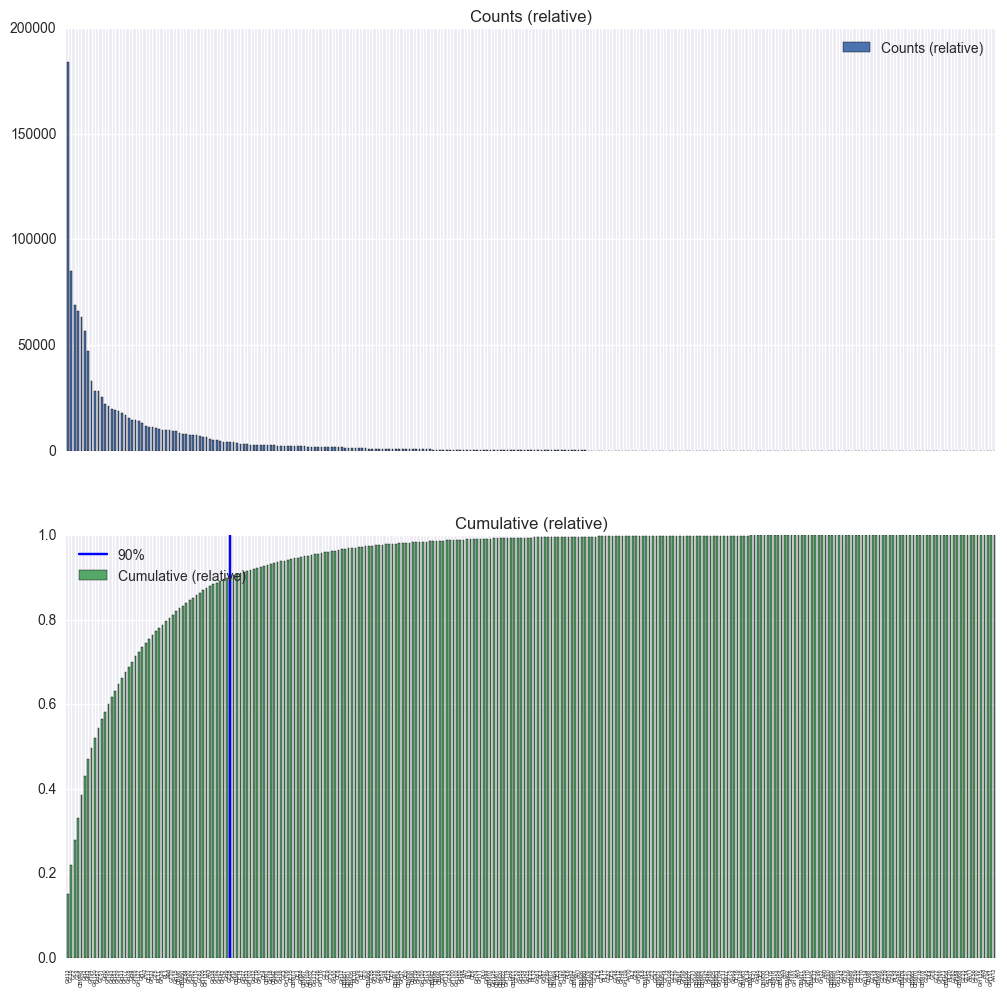

In [11]:
cumsum = pd.DataFrame(data={
                      'Counts (relative)': counts, 
                      'Cumulative (relative)': counts.cumsum() / counts.sum()
                    })
axes = cumsum.plot.bar(subplots=True,
                       figsize=(12, 12))
for ax in axes:
    ax.tick_params(axis='x', which='major', labelsize=4)
    
axes[1].axvline(bisect(cumsum['Cumulative (relative)'], .9),
                label="90%")
axes[1].legend(loc='best')

### Filtering families with more than 1% relative abundance

In [12]:
most_abundant = counts[(counts / counts.sum()) > .01]
most_abundant

GH13     183732
GT35      85165
GT2       69174
GT4       65955
CBM48     63500
GH2       56856
GH3       47023
GH94      33184
GH130     28417
GH57      28231
GT51      25315
GH0       22021
GH95      21304
GH43      19885
GH51      19182
GH29      18848
GH31      17792
GH77      16912
GH78      15296
GH4       14783
GH65      14591
GH127     13898
GH1       13213
Name: subject, dtype: int64

In [13]:
len(most_abundant)

23

In [14]:
abundances = pd.DataFrame({
        "Most abundant (absolute)": most_abundant,
        "Most abundant (relative)": most_abundant / counts.sum()})
abundances

,Most abundant (absolute),Most abundant (relative)
GH13,183732,0.151132
GT35,85165,0.070054
GT2,69174,0.056900
GT4,65955,0.054253
CBM48,63500,0.052233
GH2,56856,0.046768
GH3,47023,0.038680
GH94,33184,0.027296
GH130,28417,0.023375
GH57,28231,0.023222


The 23 families with more than 1% relative abundance account for 72% of the matches:

In [15]:
abundances['Most abundant (relative)'].sum(), len(abundances)

(0.73560483111417829, 23)

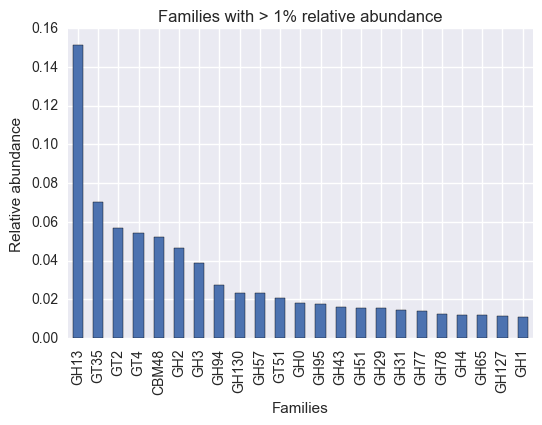

In [16]:
ax = abundances['Most abundant (relative)'].plot.bar()
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.set_title("Families with > 1% relative abundance")

## Analysis per depth

In [17]:
abundance = pd.DataFrame(abundances_per_depth)
abundance.sort_values(by=2, ascending=False, inplace=True)

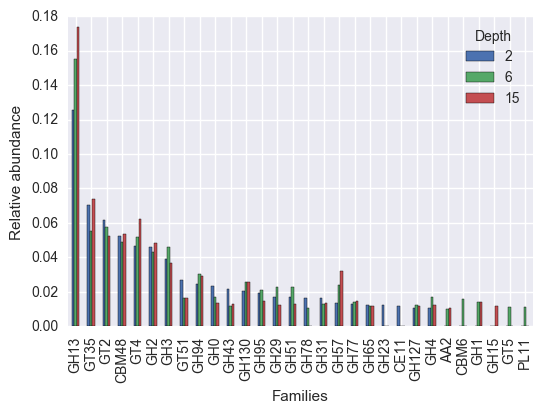

In [18]:
ax = abundance.plot.bar()
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

Some families are abundant in some families but not in others (see families to the right),
so we have two approaches: 
  - Only use families with relative abundance > 1% in every depth,
  - select all families with relative abundance > 1% in any depth, even if it is less than that in other depths.

In [19]:
abundance

,2,6,15
GH13,0.125287,0.155167,0.173755
GT35,0.070395,0.055138,0.073662
GT2,0.061735,0.057682,0.052265
CBM48,0.052128,0.048725,0.053251
GT4,0.046303,0.051877,0.062161
GH2,0.046188,0.042832,0.048334
GH3,0.038874,0.045997,0.036579
GT51,0.026767,0.016446,0.016527
GH94,0.024234,0.030505,0.029259
GH0,0.023610,0.016692,0.013451


In [20]:
abundance.sum()

2     0.728306
6     0.789736
15    0.768703
dtype: float64

In [21]:
abundance.describe()

/home/chick/.virtualenvs/cazy/lib/python3.4/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,2,6,15
count,24.000000,27.000000,24.000000
mean,0.030346,0.029249,0.032029
std,0.026486,0.029442,0.035520
min,0.010725,0.010225,0.010443
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,0.125287,0.155167,0.173755


### Using only families with relative abundance >1% in every depth

In this case, we drop any family containing `NaN` (not a number) in our abundance dataframe.

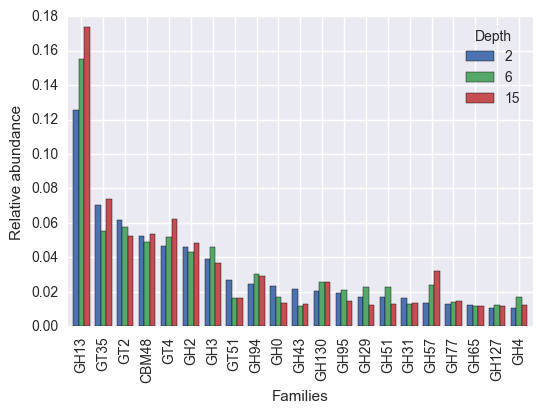

In [22]:
ax = abundance.dropna().plot.bar(width=.75)
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

In [23]:
abundance.dropna()

,2,6,15
GH13,0.125287,0.155167,0.173755
GT35,0.070395,0.055138,0.073662
GT2,0.061735,0.057682,0.052265
CBM48,0.052128,0.048725,0.053251
GT4,0.046303,0.051877,0.062161
GH2,0.046188,0.042832,0.048334
GH3,0.038874,0.045997,0.036579
GT51,0.026767,0.016446,0.016527
GH94,0.024234,0.030505,0.029259
GH0,0.023610,0.016692,0.013451


In [24]:
abundance.sum()

2     0.728306
6     0.789736
15    0.768703
dtype: float64

In [25]:
abundance.dropna().describe()

,2,6,15
count,21.000000,21.000000,21.000000
mean,0.032765,0.034134,0.034905
std,0.027512,0.031827,0.037164
min,0.010725,0.011569,0.011683
25%,0.016302,0.016446,0.013017
50%,0.021642,0.022934,0.016527
75%,0.046188,0.045997,0.048334
max,0.125287,0.155167,0.173755


### Using families with relative abundance >1% in any depth

In [26]:
families_to_track = abundance.index

any_abundances_per_depth = {}

for depth in DEPTHS:
    counts = samples_per_depth[depth]['families'].value_counts()
    most_common = counts[families_to_track]

    any_abundances_per_depth[depth] = most_common / samples_per_depth[depth]['families'].count()

In [27]:
abundance = pd.DataFrame(any_abundances_per_depth)
abundance.sort_values(by=2, ascending=False, inplace=True)

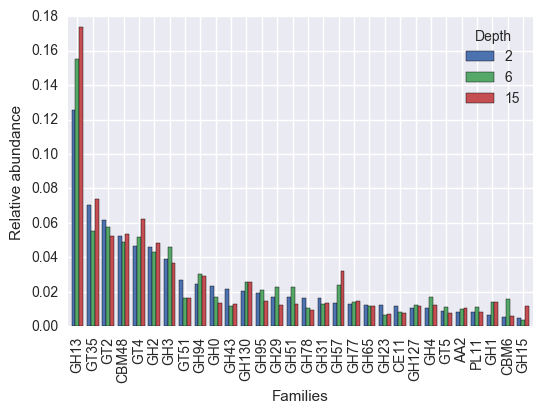

In [28]:
ax = abundance.dropna().plot.bar(width=.75)
ax.set_ylabel("Relative abundance")
ax.set_xlabel("Families")
ax.legend(loc='best', title="Depth")

In [29]:
abundance

,2,6,15
GH13,0.125287,0.155167,0.173755
GT35,0.070395,0.055138,0.073662
GT2,0.061735,0.057682,0.052265
CBM48,0.052128,0.048725,0.053251
GT4,0.046303,0.051877,0.062161
GH2,0.046188,0.042832,0.048334
GH3,0.038874,0.045997,0.036579
GT51,0.026767,0.016446,0.016527
GH94,0.024234,0.030505,0.029259
GH0,0.023610,0.016692,0.013451


In [30]:
abundance.sum()

2     0.770652
6     0.808079
15    0.815076
dtype: float64

In [31]:
abundance.describe()

,2,6,15
count,30.000000,30.000000,30.000000
mean,0.025688,0.026936,0.027169
std,0.025429,0.028763,0.033146
min,0.004771,0.003765,0.006003
25%,0.011068,0.011605,0.011515
50%,0.016522,0.016566,0.013505
75%,0.026134,0.029289,0.031159
max,0.125287,0.155167,0.173755


## Calculating mean and standard deviation

First we group results by depth and replicates. This is an example of the first hit for each depth and replicate:

In [32]:
d = samples_df.groupby(('depth', 'rep'))
d.first()

query           subject  \
depth rep                                                               
2     1     DCV4KXP1:244:C3ETWACXX:7:1101:8471:2362   ADG89028.1|GH43   
      2    DCV4KXP1:244:C3ETWACXX:7:1101:20849:2985    AFL74598.1|GT2   
      3    DCV4KXP1:244:C3ETWACXX:7:1101:10947:2751  ACY02049.1|GH117   
6     1     DCV4KXP1:244:C3ETWACXX:7:1101:2154:2988   AHO16406.1|GH13   
      2     DCV4KXP1:244:C3ETWACXX:7:1101:3189:3697    AEI64652.1|GH1   
      3     DCV4KXP1:244:C3ETWACXX:7:1101:4013:2572   ACL70506.1|CE11   
15    1    DCV4KXP1:244:C3ETWACXX:7:1101:13454:3214  AMV35491.1|CBM51   
      2     DCV4KXP1:244:C3ETWACXX:7:1101:5150:2375    AGP33317.1|GH8   
      3    DCV4KXP1:244:C3ETWACXX:7:1101:19175:2271    ABN57689.1|GT4   

           percent_id  alignment_length  mismatches  gap_openings  q_start  \
depth rep                                                                    
2     1          75.4                57          14             0        1   
      2          83.7                43           7             0        1   
      3          47.0               115           9             1      192   
6     1          68.9                61          19             0      185   
      2          42.4                99          18             1        2   
      3          54.0                63          29             0        5   
15    1          77.5                40           9             0        2   
      2          76.3                59          14             0        3   
      3          63.0                46          17             0       22   

           q_end  s_start  s_end       e_value  bit_score family  
depth rep                                                         
2     1      171       30     86  5.200000e-20       98.2   GH43  
      2      129     1666   1708  3.500000e-13       75.1    GT2  
      3        4      195    309  2.000000e-20       99.8    GT4  
6     1        3      170    230  1.500000e-17       90.1   GH13  
      2      181       91    189  1.800000e-15       83.2   CBM6  
      3      193       81    143  4.800000e-11       68.6   CBM6  
15    1      121      340    379  3.200000e-13       75.1  CBM51  
      2      179      334    392  5.600000e-22      104.8    GH8  
      3      159      116    161  1.300000e-12       73.6    GT4

Next, we need to count how many times each family occured in each depth and replicate:

In [33]:
f = d['family'].value_counts()
f.head()

depth  rep  family
2      1    GH13      33542
            GT35      17820
            GT2       16660
            CBM48     13041
            GH2       12956
Name: family, dtype: int64

And we can want to sum all matches per depth and replicate to calculate the relative abundance:

In [34]:
totals = f.sum(level=('depth', 'rep'))
totals

depth  rep
2      1      271225
       2       94206
       3      145787
6      1       53681
       2       30190
       3       62726
15     1      125369
       2      351935
       3       80584
Name: family, dtype: int64

In [35]:
frel = (f.unstack(level=('depth', 'rep')) / totals).stack(level=('depth', 'rep'))
frel

family  depth  rep
AA0     15     2      0.000017
               3      0.000050
AA1     2      1      0.000435
               2      0.000212
AA10    2      1      0.000229
               2      0.000021
               3      0.000034
        6      1      0.000019
        15     2      0.000031
               3      0.000099
AA11    15     2      0.000003
AA12    6      1      0.000019
AA2     2      1      0.007614
               2      0.008577
               3      0.009329
        6      1      0.011065
               2      0.008480
               3      0.010347
        15     1      0.009005
               2      0.011843
               3      0.006565
AA3     2      1      0.007433
               2      0.001560
               3      0.009617
        6      1      0.003912
               2      0.000166
        15     1      0.000798
               2      0.002262
               3      0.008314
AA4     15     2      0.000048
                        ...   
PL6     15     1    

In [36]:
#std_err = frel.sem(level=('depth', 'family'))
std_err = frel.std(level=('depth', 'family'))
std_err.head()

depth  family
2      AA1       0.000158
       AA10      0.000116
       AA2       0.000860
       AA3       0.004167
       AA5       0.000007
dtype: float64

In [37]:
m = frel.mean(level=('depth', 'family'))
m

depth  family
2      AA1       0.000324
       AA10      0.000095
       AA2       0.008506
       AA3       0.006203
       AA5       0.000024
       AA6       0.006228
       AA7       0.000409
       CBM0      0.000492
       CBM1      0.000047
       CBM10     0.000292
       CBM11     0.000206
       CBM12     0.000064
       CBM13     0.001747
       CBM14     0.000046
       CBM16     0.000011
       CBM18     0.000032
       CBM2      0.002017
       CBM20     0.000264
       CBM22     0.000230
       CBM23     0.000042
       CBM25     0.000094
       CBM26     0.000175
       CBM27     0.000056
       CBM3      0.002545
       CBM30     0.000027
       CBM32     0.001651
       CBM34     0.000710
       CBM35     0.001223
       CBM36     0.000067
       CBM37     0.000044
                   ...   
15     GT8       0.000059
       GT81      0.004550
       GT83      0.000179
       GT84      0.007660
       GT87      0.001241
       GT89      0.000616
       GT9       0.00052

In [38]:
s = m[m > 0.01]
s

depth  family
2      CBM48     0.054062
       CE11      0.011316
       GH0       0.024376
       GH127     0.010259
       GH13      0.127140
       GH130     0.019272
       GH2       0.045911
       GH23      0.012476
       GH29      0.017082
       GH3       0.038381
       GH31      0.015756
       GH4       0.010870
       GH43      0.020392
       GH51      0.016409
       GH57      0.013689
       GH65      0.011890
       GH77      0.011886
       GH78      0.016659
       GH94      0.024944
       GH95      0.019648
       GT2       0.061418
       GT35      0.071168
       GT4       0.047240
       GT51      0.027500
6      CBM48     0.050580
       CBM6      0.017200
       GH0       0.018115
       GH1       0.013943
       GH127     0.012961
       GH13      0.158536
                   ...   
       GT2       0.057030
       GT35      0.054761
       GT4       0.050476
       GT5       0.010505
       GT51      0.016157
       PL11      0.010870
15     AA6       0.01118

In [39]:
import requests
from bs4 import BeautifulSoup

def extract_names(url):
    data = requests.get(url)
    soup = BeautifulSoup(data.content, 'html.parser')
    return "".join(soup.find('td', class_='tdsum').strings).split('; ')

Each family can have many different known activities:

In [40]:
extract_names("http://www.cazy.org/GH13.html")

['α-amylase (EC 3.2.1.1)',
 'pullulanase (EC 3.2.1.41)',
 'cyclomaltodextrin glucanotransferase (EC 2.4.1.19)',
 'cyclomaltodextrinase (EC 3.2.1.54)',
 'trehalose-6-phosphate hydrolase (EC 3.2.1.93)',
 'oligo-α-glucosidase (EC 3.2.1.10)',
 'maltogenic amylase (EC 3.2.1.133)',
 'neopullulanase (EC 3.2.1.135)',
 'α-glucosidase (EC 3.2.1.20)',
 'maltotetraose-forming α-amylase (EC 3.2.1.60)',
 'isoamylase (EC 3.2.1.68)',
 'glucodextranase (EC 3.2.1.70)',
 'maltohexaose-forming α-amylase (EC 3.2.1.98)',
 'maltotriose-forming α-amylase (EC 3.2.1.116)',
 'branching enzyme (EC 2.4.1.18)',
 'trehalose synthase (EC 5.4.99.16)',
 '4-α-glucanotransferase (EC 2.4.1.25)',
 'maltopentaose-forming α-amylase (EC 3.2.1.-) ',
 'amylosucrase (EC 2.4.1.4) ',
 'sucrose phosphorylase (EC 2.4.1.7)',
 'malto-oligosyltrehalose trehalohydrolase (EC 3.2.1.141)',
 'isomaltulose synthase (EC 5.4.99.11)',
 'malto-oligosyltrehalose synthase (EC 5.4.99.15)',
 'amylo-α-1,6-glucosidase (EC 3.2.1.33)',
 'α-1,4-glucan: p

I extracted the first known activity to make it fit in the figure:

In [41]:
names = {}
families = s.unstack(level='depth').sort_values(by=2, ascending=False)

for f in families.index:
    names[f] = extract_names("http://www.cazy.org/{}.html".format(f))[0]

But... Known activity is not a good proxy for family name, because families have many known activities and they also share activities in common with others. This means we have 3 activities matching more than one family, and some families have very long names (they are descriptions of how the activities were found):

In [42]:
fnames = pd.Series(names)
fnames.value_counts()

β-glucosidase (EC 3.2.1.21)                                                                                                                                                                                                    2
α-L-fucosidase (EC 3.2.1.51)                                                                                                                                                                                                   2
α-amylase (EC 3.2.1.1)                                                                                                                                                                                                         2
endoglucanase (EC 3.2.1.4)                                                                                                                                                                                                     1
Glycoside hydrolases not yet assigned to a family.                                                  

In [43]:
new_index_names = {}
for k,v in names.items():
    new_index_names[k] = "{}: {}".format(k, v)
new_index_names

{'AA6': 'AA6: 1,4-benzoquinone reductase (EC. 1.6.5.6)',
 'CBM48': 'CBM48: Modules of approx. 100 residues with glycogen-binding function, appended to GH13 modules. Also found in the beta subunit (glycogen-binding) of AMP-activated protein kinases (AMPK)',
 'CBM6': 'CBM6: Modules of approx. 120 residues. The cellulose-binding function has been demonstrated in one case on amorphous cellulose and β-1,4-xylan. Some of these modules also bind β-1,3-glucan, β-1,3-1,4-glucan, and β-1,4-glucan.',
 'CE11': 'CE11: UDP-3-0-acyl N-acetylglucosamine deacetylase (EC 3.5.1.-).',
 'GH0': 'GH0: Glycoside hydrolases not yet assigned to a family. ',
 'GH1': 'GH1: β-glucosidase (EC 3.2.1.21)',
 'GH127': 'GH127: β-L-arabinofuranosidase (EC 3.2.1.185)',
 'GH13': 'GH13: α-amylase (EC 3.2.1.1)',
 'GH130': 'GH130: β-1,4-mannosylglucose phosphorylase (EC 2.4.1.281)',
 'GH15': 'GH15: glucoamylase (EC 3.2.1.3)',
 'GH2': 'GH2: β-galactosidase (EC 3.2.1.23) ',
 'GH23': 'GH23: lysozyme type G (EC 3.2.1.17)',
 'GH29

In [44]:
families.rename(index=new_index_names, inplace=True)
yerr = std_err.unstack('depth').rename(index=new_index_names)

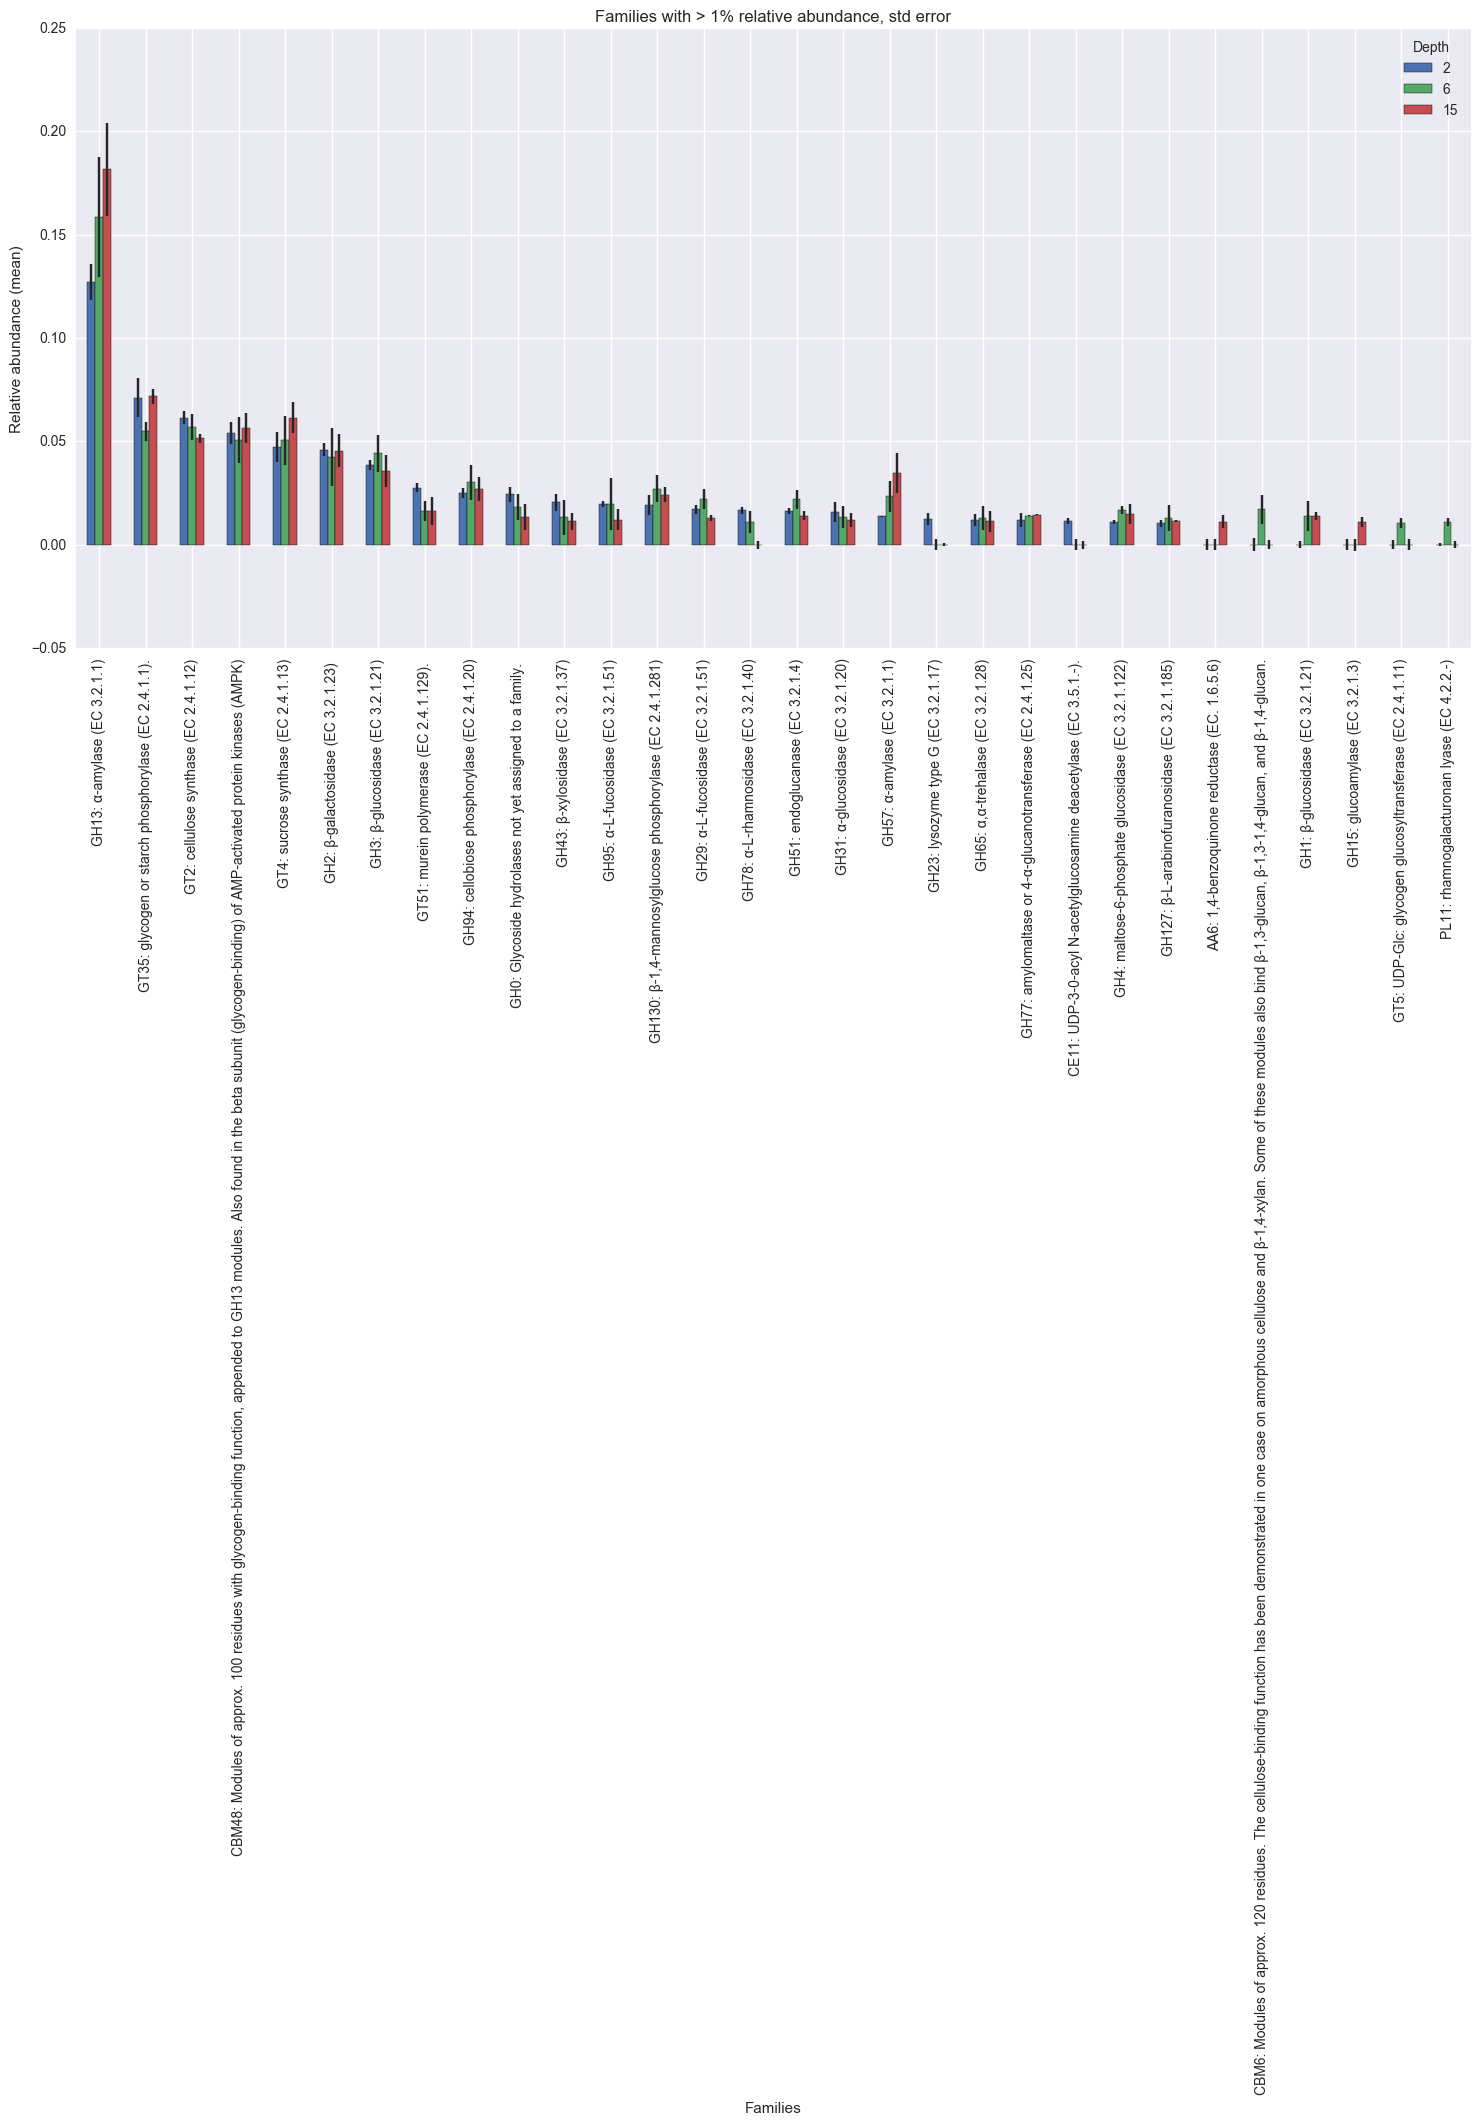

In [45]:
ax = (families.plot.bar(yerr=yerr, figsize=(18, 8)))
ax.set_ylabel("Relative abundance (mean)")
ax.set_xlabel("Families")
ax.set_title("Families with > 1% relative abundance, std error")
ax.legend(loc='best', title="Depth")
!mkdir -p ../outputs/figures
ax.figure.savefig("../outputs/figures/relative_abundances_1percent.svg")
ax.figure.savefig("../outputs/figures/relative_abundances_1percent.pdf")
ax.figure.savefig("../outputs/figures/relative_abundances_1percent.eps")
ax.figure.savefig("../outputs/figures/relative_abundances_1percent.png")

In [46]:
st = pd.DataFrame({"Relative abundance (mean)": m,
                   "Standard deviation": std_err}).reset_index()
s1p = st[st["Relative abundance (mean)"] > 0.01].sort_values(by="Standard deviation", ascending=False)
s1p

,depth,family,Relative abundance (mean),Standard deviation
341,6,GH13,0.158536,0.028845
568,15,GH13,0.181635,0.022602
349,6,GH2,0.042359,0.013937
405,6,GH95,0.019691,0.012487
427,6,GT4,0.050476,0.011975
280,6,CBM48,0.050580,0.011026
613,15,GH57,0.034634,0.009761
201,2,GT35,0.071168,0.009610
358,6,GH3,0.044105,0.009095
106,2,GH13,0.127140,0.008720


## Saving data to disk

In [47]:
!mkdir -p ../outputs/abundances
s1p.to_csv("../outputs/abundances/relative_abundances_1percent.csv")

In [48]:
frel.to_csv("../outputs/abundances/relative_abundances_all.csv")

Not saving `samples_df` because it is too big (~250 MB)

In [49]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2101301 entries, 0 to 142042
Data columns (total 15 columns):
query               object
subject             object
percent_id          float64
alignment_length    int64
mismatches          int64
gap_openings        int64
q_start             int64
q_end               int64
s_start             int64
s_end               int64
e_value             float64
bit_score           float64
family              object
rep                 int64
depth               int64
dtypes: float64(3), int64(9), object(3)
memory usage: 256.5+ MB
